<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [ ]:
with open('/content/wonderland.txt', 'r') as f:
    corpus = f.read()

In [ ]:
corpus

'\ufeffAlice’s Adventures in Wonderland\n\nby Lewis Carroll\n\nTHE MILLENNIUM FULCRUM EDITION 3.0\n\nContents\n\n CHAPTER I.     Down the Rabbit-Hole\n CHAPTER II.    The Pool of Tears\n CHAPTER III.   A Caucus-Race and a Long Tale\n CHAPTER IV.    The Rabbit Sends in a Little Bill\n CHAPTER V.     Advice from a Caterpillar\n CHAPTER VI.    Pig and Pepper\n CHAPTER VII.   A Mad Tea-Party\n CHAPTER VIII.  The Queen’s Croquet-Ground\n CHAPTER IX.    The Mock Turtle’s Story\n CHAPTER X.     The Lobster Quadrille\n CHAPTER XI.    Who Stole the Tarts?\n CHAPTER XII.   Alice’s Evidence\n\n\n\n\nCHAPTER I.\nDown the Rabbit-Hole\n\n\nAlice was beginning to get very tired of sitting by her sister on the\nbank, and of having nothing to do: once or twice she had peeped into\nthe book her sister was reading, but it had no pictures or\nconversations in it, “and what is the use of a book,” thought Alice\n“without pictures or conversations?”\n\nSo she was considering in her own mind (as well as she c

### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [ ]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [ ]:
corpus

'\ufeffAlice’s Adventures in Wonderland\n\nby Lewis Carroll\n\nTHE MILLENNIUM FULCRUM EDITION 3.0\n\nContents\n\n CHAPTER I.     Down the Rabbit-Hole\n CHAPTER II.    The Pool of Tears\n CHAPTER III.   A Caucus-Race and a Long Tale\n CHAPTER IV.    The Rabbit Sends in a Little Bill\n CHAPTER V.     Advice from a Caterpillar\n CHAPTER VI.    Pig and Pepper\n CHAPTER VII.   A Mad Tea-Party\n CHAPTER VIII.  The Queen’s Croquet-Ground\n CHAPTER IX.    The Mock Turtle’s Story\n CHAPTER X.     The Lobster Quadrille\n CHAPTER XI.    Who Stole the Tarts?\n CHAPTER XII.   Alice’s Evidence\n\n\n\n\nCHAPTER I.\nDown the Rabbit-Hole\n\n\nAlice was beginning to get very tired of sitting by her sister on the\nbank, and of having nothing to do: once or twice she had peeped into\nthe book her sister was reading, but it had no pictures or\nconversations in it, “and what is the use of a book,” thought Alice\n“without pictures or conversations?”\n\nSo she was considering in her own mind (as well as she c

In [ ]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[100:120]

['tired',
 'of',
 'sitting',
 'by',
 'her',
 'sister',
 'on',
 'the',
 'bank',
 'and',
 'of',
 'having',
 'nothing',
 'to',
 'do',
 'once',
 'or',
 'twice',
 'she',
 'had']

In [ ]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 27748


In [ ]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['\ufeffalice’s', 'adventures', 'in', 'wonderland'],
 ['adventures', 'in', 'wonderland', 'by'],
 ['in', 'wonderland', 'by', 'lewis'],
 ['wonderland', 'by', 'lewis', 'carroll'],
 ['by', 'lewis', 'carroll', 'the'],
 ['lewis', 'carroll', 'the', 'millennium'],
 ['carroll', 'the', 'millennium', 'fulcrum'],
 ['the', 'millennium', 'fulcrum', 'edition'],
 ['millennium', 'fulcrum', 'edition', '3'],
 ['fulcrum', 'edition', '3', '0'],
 ['edition', '3', '0', 'contents'],
 ['3', '0', 'contents', 'chapter'],
 ['0', 'contents', 'chapter', 'i'],
 ['contents', 'chapter', 'i', 'down'],
 ['chapter', 'i', 'down', 'the'],
 ['i', 'down', 'the', 'rabbit'],
 ['down', 'the', 'rabbit', 'hole'],
 ['the', 'rabbit', 'hole', 'chapter'],
 ['rabbit', 'hole', 'chapter', 'ii'],
 ['hole', 'chapter', 'ii', 'the']]

In [ ]:
# Proceso de tokenización
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[3062, 628, 11, 875],
 [628, 11, 875, 70],
 [11, 875, 70, 1594],
 [875, 70, 1594, 1595],
 [70, 1594, 1595, 1],
 [1594, 1595, 1, 1596],
 [1595, 1, 1596, 1597],
 [1, 1596, 1597, 1598],
 [1596, 1597, 1598, 1599],
 [1597, 1598, 1599, 1600],
 [1598, 1599, 1600, 1601],
 [1599, 1600, 1601, 176],
 [1600, 1601, 176, 14],
 [1601, 176, 14, 35],
 [176, 14, 35, 1],
 [14, 35, 1, 88],
 [35, 1, 88, 629],
 [1, 88, 629, 176],
 [88, 629, 176, 1134],
 [629, 176, 1134, 1]]

In [ ]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 27744


### 3 - Input y target

In [ ]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [ ]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [ ]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [ ]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(27744, 3)
(27744,)


In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: '”',
 3: 'and',
 4: 'to',
 5: 'a',
 6: 'she',
 7: 'of',
 8: 'it',
 9: 'said',
 10: 'alice',
 11: 'in',
 12: 'was',
 13: 'you',
 14: 'i',
 15: 'that',
 16: 'as',
 17: 'her',
 18: 'at',
 19: 'on',
 20: 'with',
 21: 'had',
 22: 'all',
 23: 'be',
 24: 'for',
 25: 'so',
 26: 'very',
 27: 'not',
 28: 'this',
 29: 'little',
 30: 'but',
 31: '“i',
 32: 'they',
 33: 'out',
 34: 'he',
 35: 'down',
 36: 'what',
 37: 'up',
 38: 'is',
 39: 'one',
 40: 'his',
 41: 'about',
 42: 'were',
 43: 'like',
 44: 'went',
 45: 'herself',
 46: 'them',
 47: 'again',
 48: 'know',
 49: 'then',
 50: 'would',
 51: 'could',
 52: 'have',
 53: 'no',
 54: 'thought',
 55: 'when',
 56: 'if',
 57: 'do',
 58: 'time',
 59: 'or',
 60: 'there',
 61: 'queen',
 62: 'into',
 63: 'me',
 64: 'see',
 65: 'off',
 66: 'king',
 67: 'your',
 68: 'did',
 69: 'began',
 70: 'by',
 71: 'mock',
 72: 'its',
 73: 'an',
 74: 'my',
 75: 'turtle',
 76: 'who',
 77: '“and',
 78: 'quite',
 79: 'hatter',
 80: 'gryphon',
 81: 'way',
 82

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3062

In [ ]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [ ]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(27744, 3062)

### 4 - Entrenar el modelo

In [ ]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

3

In [ ]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3062

In [ ]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=15, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(64, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3, 15)             45945     
                                                                 
 lstm_6 (LSTM)               (None, 3, 64)             20480     
                                                                 
 dropout_3 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 3062)              199030    
                                                                 
Total params: 302,639
Trainable params: 302,639
Non-tr

In [ ]:
def data_generator(x_data, y_data, batch_size):
    num_samples = len(x_data)
    while True:
        indices = np.random.permutation(num_samples)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            yield x_data[batch_indices], y_data[batch_indices]

# Luego, puedes usar el generador de datos en lugar de los datos originales en el método fit
batch_size = 10  # Puedes ajustar este valor según tus necesidades
generator = data_generator(x_data, y_data, batch_size)

# Calcular el número de pasos por época (steps_per_epoch)
steps_per_epoch = len(x_data) // batch_size

# Separar datos de validación (puedes ajustar la cantidad de datos para la validación)
validation_split = 0.2
num_validation_samples = int(validation_split * len(x_data))
validation_data = next(generator)

# Entrenar el modelo con el generador de datos y datos de validación
model.fit(generator, epochs=50, steps_per_epoch=steps_per_epoch, validation_data=validation_data)



Epoch 1/50
 29643/131654 [=====>........................] - ETA: 47:00 - loss: 7.1046 - accuracy: 0.0404

In [ ]:
hist = model.fit(x_data, y_data, epochs=250, validation_split=0.2)

Epoch 1/250
694/694 [==============================] - 26s 30ms/step - loss: 6.4261 - accuracy: 0.0531 - val_loss: 6.3840 - val_accuracy: 0.0786
Epoch 2/250
694/694 [==============================] - 18s 26ms/step - loss: 6.0896 - accuracy: 0.0533 - val_loss: 6.3331 - val_accuracy: 0.0786
Epoch 3/250
694/694 [==============================] - 15s 21ms/step - loss: 5.9569 - accuracy: 0.0549 - val_loss: 6.3033 - val_accuracy: 0.0802
Epoch 4/250
694/694 [==============================] - 18s 25ms/step - loss: 5.7683 - accuracy: 0.0613 - val_loss: 6.2968 - val_accuracy: 0.0824
Epoch 5/250
694/694 [==============================] - 17s 24ms/step - loss: 5.5955 - accuracy: 0.0665 - val_loss: 6.3210 - val_accuracy: 0.0939
Epoch 6/250
694/694 [==============================] - 16s 24ms/step - loss: 5.4445 - accuracy: 0.0729 - val_loss: 6.3172 - val_accuracy: 0.0959
Epoch 7/250
694/694 [==============================] - 15s 21ms/step - loss: 5.2996 - accuracy: 0.0833 - val_loss: 6.4778 - val_ac

KeyboardInterrupt: ignored

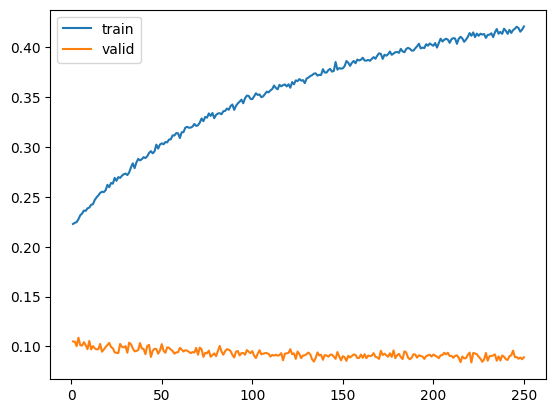

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.8 MB/s eta 0:

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

<ipython-input-32-8850fd72ce56>:24: GradioDeprecationWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 27ms/step
Keyboard interruption in main thread... closing server.


In [ ]:
model.save('alice-nlp-1.h5')